# Final Project: Euchre
Tyler Gibson & Carter Shavitz | CSC 5661

https://en.wikipedia.org/wiki/Euchre

https://cardgames.io/euchre/

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # needed to do as sometimes kernel died

In [2]:
import random

import numpy as np
import re
import time

import tqdm
import pickle

import players
from score import Score

from players import Player
from players import RandomAgent
from players import DQNAgent

import matplotlib.pyplot as plt

## Euchre Environment

In [3]:
class Euchre:
    """
    A class to manage the euchre board.
    """

    def __init__(self, config: dict) -> None:
        """
        The constructor for the class.

        Parameters
        ----------
        config : dict
            The configuration parameters for euchre.
        """
        self.config = config
        self.score_to_win = self.config['score_to_win']  # 5, 7, or 10
        self.values = self.config['values']  # 9 - A that can include 7's and/or 8's

        self.num_players = 4  # the numbers of players in the game
        self.suits = ['♠', '♥', '♦', '♣']  # the card suits
        self.regex_suits = r'[♠♥♦♣]'
        self.deck = [f"{value}{suit}" for suit in self.suits for value in self.values]  # the valid deck of cards
        self.master_deck = self.deck.copy()

        self.hand_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}
        self.trick_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}


        self.score = Score()  # score class

        self.team_1_score = 0  # keep track of team 1 score
        self.team_2_score = 0  # keep track of team 2 score
        
        self.top_card = None  # the top card after the deal
        self.dealer_id = 1  # the current dealer
        self.lead_suit = -1  # the lead suit
        self.trump_suit = -1  # the trump suit for the trick

        self.card_num = {card: index for index, card in enumerate(self.master_deck)}  # the numerical encoding of the card
        self.suit_num = {suit: index for index, suit in enumerate(self.suits)}  # the numerical encoding of the suit

        self.hand_strength_weak_threshold = 20
        self.hand_strength_strong_threshold = 30

    def get_state(self, player: Player, phase: int):
        return np.array(
            [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
            [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
            [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
            [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
            [self.card_num[self.top_card]] +  # the top card
            [self.dealer_id] + # the current dealer id
            [player.id] +  # the current player id
            [phase] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
            [self.team_1_score, self.team_2_score] +  # the team scores
            [1 if card in player.hand else 0 for card in self.deck]  # the current players hand state of available cards
        ).flatten().tolist()  # add state information

    def deal_cards(self, distribution_pattern=(3, 2)):
        """
        Deal the cards for a new round.

        Parameters
        ----------
        distribution_pattern : tuple
            The distribution pattern on how to distribute the cards to players, default = (3, 2)

        Returns
        -------
        players_hands : dict
            A dictionary where: key = player id, value = list of cards
        self.deck[deck_index] : str
            The top card of the deck after cards have been distributed.
        """
        random.shuffle(self.deck)  # suffle the deck
    
        players_hands = {  # init dict to hold players cards
            '1': [],
            '2': [],
            '3': [],
            '4': []
        }

        deck_index = 0  # index to traverse the deck
        for count, player in enumerate(list(players_hands.keys()) * 2):  # loop though to distribute cards to players
            if (count % 2 == 0 and count < len(players_hands)) or (count % 2 == 1 and count >= len(players_hands)):
                players_hands[player].append(self.deck[deck_index:deck_index+distribution_pattern[0]])
                deck_index += distribution_pattern[0] 
            else:
                players_hands[player].append(self.deck[deck_index:deck_index+distribution_pattern[1]])
                deck_index += distribution_pattern[1]

        for key in players_hands.keys():
            players_hands[key] =  [item for sublist in players_hands[key] for item in sublist]
                    
        return players_hands, self.deck[deck_index]
    
    def choose_trump(self, players):
        """
        First part of the game where the players choose what trump is. It can be the top card
        in the first round of choices, or any different suit in the second round of deciding.
        """
        trump = None
        count = 0
        dealer = self.dealer_id
        decider = dealer % 4
        player = -1


        while trump == None: #while trump not selected
            count += 1
            decider = decider % 4 + 1
            for p in players: #get the current player
                if p.id == decider:
                    player = p
            call = player.choose_trump('', re.findall(self.regex_suits, self.top_card)[0], self.suits, count)
            if call == 'pass': #if call or a suit, set trump
                pass
            elif call == 'call':
                trump = re.findall(self.regex_suits, self.top_card)[0]
            elif call in self.suits:
                trump = call

        self.trump_suit = trump
        if count <= 4: #if card called up (in first four) add, then remove card from dealer
            dealer = [p for p in players if p.id == self.dealer_id][0]  # get dealer based on id
            dealer.hand.append(self.top_card)
            dealer.discard_card()
        player.trick_team = 'makers'  # assign the first player as the Makers

        makers = player.team_id  # set makers to player team who chose trump
        for p in players:
            p.trick_team = 'makers' if p.team_id == makers else 'defenders'
        
        return player, players
    
    def reset_game(self, players: list[Player]):
        """
        Reset the game.
        """
        self.team_1_score = 0
        self.team_2_score = 0
        self.top_card = None
        self.dealer_id = np.random.choice(range(self.num_players)) + 1
        players = self.reset_hand(players=players)

        return players

    def reset_hand(self, players: list[Player]):
        """
        Reset the hand.
        """
        self.hand_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}

        for player in players:
            player.points = 0
            
        players_hands, top_card = self.deal_cards(distribution_pattern=(3, 2))

        for count, player in enumerate(players):
            player.set_hand(players_hands[str(count + 1)])

        self.top_card = top_card

        self.reset_trick()
        
        return players

    def reset_trick(self):
        """
        Reset the trick.
        """
        self.dealer_id = 1 if self.dealer_id == 4 else self.dealer_id + 1  
        self.trick_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}

    def update_team_scores(self, players: list[Player], player_team_id_trump: int):
        """
        Update the team scores.
        """
        hand_scores = self.score.score_hand(players, solo_call=False)  # calculate the hand scores by looking at each players points for all tricks
            
        # update team scores
        if player_team_id_trump == 1:
            self.team_1_score += hand_scores['makers']
            self.team_2_score += hand_scores['defenders']
        else:
            self.team_2_score += hand_scores['makers']
            self.team_1_score += hand_scores['defenders']
        
        return True if self.team_1_score >= 10 or self.team_2_score >= 10 else False
    
    def reward_based_on_card(self, card):
        suit = card[-1]
        if suit == self.trump_suit:
            reward = 1
        if card[-1] == self.lead_suit:
            reward = 0.5
        else:
            reward = -1
        return reward
        
    def step(self, action, player: Player, **kwargs) -> dict:
        """
        TODO

        Parameters
        ----------
        a : TODO
            TODO

        Returns
        -------
        dict
            TODO
        """
        action_str = kwargs.get('action_str', None)
        phase_str = kwargs['phase_str']

        if phase_str == "bidding":
            if action_str == "pass":
                hand_strength = self.score.calculate_hand_strength(player.hand, trump_suit=self.top_card[-1])
                if hand_strength < self.hand_strength_weak_threshold:
                    reward = 0.5
                else:
                    reward = -0.5

                next_player_id = player.id % 4 + 1
                if kwargs['iteration'] == 4:
                    phase = 2
                else:
                    phase = 0
                state = np.array(
                    [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
                    [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
                    [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
                    [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
                    [self.card_num[self.top_card]] +  # the top card
                    [self.dealer_id] + # the current dealer id
                    [next_player_id] +  # the current player id
                    [phase] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
                    [self.team_1_score, self.team_2_score] +  # the team scores
                    [0 for _ in self.deck]  # the current players hand state of available cards
                ).flatten().tolist()
            elif action_str == "order_up":
                self.trump_suit = self.top_card[-1]
                hand_strength = self.score.calculate_hand_strength(hand=player.hand, trump_suit=self.trump_suit)
                if hand_strength > self.hand_strength_weak_threshold:
                    reward = 0.5
                else:
                    reward =- 0.5

                state = np.array(
                    [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
                    [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
                    [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
                    [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
                    [self.card_num[self.top_card]] +  # the top card
                    [self.dealer_id] + # the current dealer id
                    [self.dealer_id] +  # the current player id
                    [1] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
                    [self.team_1_score, self.team_2_score] +  # the team scores
                    [0 for _ in self.deck]  # the current players hand state of available cards
                ).flatten().tolist()
        elif phase_str == "remove_card":
            before_hand_strength = self.score.calculate_hand_strength(kwargs['before_hand'], trump_suit=self.trump_suit)
            after_hand_strength = self.score.calculate_hand_strength(player.hand, trump_suit=self.trump_suit)
            if after_hand_strength < before_hand_strength:
                reward = 0.5
            else:
                reward = -0.5

            state = np.array(
                [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
                [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
                [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
                [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
                [self.card_num[self.top_card]] +  # the top card
                [self.dealer_id] + # the current dealer id
                [self.dealer_id] +  # the current player id
                [3] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
                [self.team_1_score, self.team_2_score] +  # the team scores
                [0 for _ in self.deck]  # the current players hand state of available cards
            ).flatten().tolist()
        elif phase_str == "trump_selection":
            if action_str == "pass":
                max_hand_strength = 0
                for suit in self.suits:
                    hand_strength = self.score.calculate_hand_strength(player.hand, trump_suit=suit)
                    if max_hand_strength < hand_strength:
                        max_hand_strength = hand_strength
                if hand_strength < self.hand_strength_weak_threshold:
                    reward = 0.5
                else:
                    reward = -0.5

                next_player_id = player.id % 4 + 1
                phase = 2
                state = np.array(
                    [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
                    [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
                    [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
                    [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
                    [self.card_num[self.top_card]] +  # the top card
                    [self.dealer_id] + # the current dealer id
                    [next_player_id] +  # the current player id
                    [phase] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
                    [self.team_1_score, self.team_2_score] +  # the team scores
                    [0 for _ in self.deck]  # the current players hand state of available cards
                ).flatten().tolist()
            elif action_str == "select_trump":
                self.trump_suit = kwargs['trump_suit']
                hand_strength = self.score.calculate_hand_strength(player.hand, trump_suit=self.trump_suit)
                if hand_strength > self.hand_strength_weak_threshold:
                    reward = 0.5
                else:
                    reward =- 0.5

                next_player_id = self.dealer_id % 4 + 1
                phase = 3
                state = np.array(
                    [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
                    [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
                    [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
                    [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
                    [self.card_num[self.top_card]] +  # the top card
                    [self.dealer_id] + # the current dealer id
                    [next_player_id] +  # the current player id
                    [phase] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
                    [self.team_1_score, self.team_2_score] +  # the team scores
                    [0 for _ in self.deck]  # the current players hand state of available cards
                ).flatten().tolist()
        elif phase_str == "trick":
            reward = self.reward_based_on_card(card=action)

            self.hand_state[action] = True
            self.trick_state[action] = True
            
            next_player_id = player.id % 4 + 1            
            phase = 3
            state = np.array(
                [1 if self.hand_state[card] else 0 for card in self.deck] +  # the hand state of the game
                [1 if self.trick_state[card] else 0 for card in self.deck] +  # the trick state of the game
                [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] +  # the lead suit
                [self.suit_num[self.trump_suit] if self.trump_suit != -1 else -1] +  # the trump suit
                [self.card_num[self.top_card]] +  # the top card
                [self.dealer_id] + # the current dealer id
                [next_player_id] +  # the current player id
                [phase] +  # the phase of the game (0 = bidding, 1 = remove card dealer, 2 = trump selection, 3 = trick)
                [self.team_1_score, self.team_2_score] +  # the team scores
                [0 for _ in self.deck]  # the current players hand state of available cards
            ).flatten().tolist()

        return {
            'state': state,
            'reward': reward,
            'done': self.team_1_score >= 10 or self.team_2_score >= 10
        }

In [4]:
def plot_results(results):
    team_1_wins = np.sum(np.array(results['team_wins']) == 1)
    team_2_wins = np.sum(np.array(results['team_wins']) == 2)

    teams = ['Team 1', 'Team 2']
    wins = [team_1_wins, team_2_wins]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(teams, wins, color=['blue', 'red'])

    for bar, win in zip(bars, wins):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(win), ha='center', va='bottom', fontsize=12, color='black')

    plt.xlabel('Teams')
    plt.ylabel('Wins')
    plt.title('Team Wins')
    plt.show()

    player_1_wins = np.sum(np.array(results['trick_wins']) == 1)
    player_2_wins = np.sum(np.array(results['trick_wins']) == 2)
    player_3_wins = np.sum(np.array(results['trick_wins']) == 3)
    player_4_wins = np.sum(np.array(results['trick_wins']) == 4)

    teams = ['Player 1', 'Player 2', 'Player 3', 'Player 4']
    wins = [player_1_wins, player_2_wins, player_3_wins, player_4_wins]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(teams, wins, color=['blue', 'orange', 'green', 'red'])

    for bar, win in zip(bars, wins):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(win), ha='center', va='bottom', fontsize=12, color='black')

    plt.xlabel('Player')
    plt.ylabel('Wins')
    plt.title('Trick Wins')
    plt.show()

In [7]:
# def simulate_games(euchre: Euchre, players: list[Player], episodes: int, debug: bool=False):
#     count = 0

#     # store results of training
#     results = {
#         'team_wins': [],
#         'individual_wins': []
#     }

#     for epi in tqdm.tqdm(range(episodes)):  # loop through episodes
#         players = euchre.reset_game(players=players)  # reset game
#         hands = 1  # keep track of which game we are on
#         done = False  # use to show when game is done

#         while not done: # continue until game is complete
#             count += 1
            
#             player_choose_trump, trump_suit, rotation = euchre.choose_trump(players)
#             euchre.trump_suit = trump_suit
#             if rotation <= 4: #if card called up (in first four) add, then remove card from dealer
#                 dealer = [player for player in players if player.id == euchre.dealer_id][0]  # get dealer based on id
#                 dealer.hand.append(euchre.top_card)
#                 dealer.discard_card()
#             #player_choose_trump = np.random.choice(players)  # assuming the player to the left of dealer chooses trump and starts (not based off of actual rules)
#             player_choose_trump.trick_team = 'makers'  # assign the first player as the Makers

#             makers = player_choose_trump.team_id  # set makers to player team who chose trump
#             for player in players:
#                 player.trick_team = 'makers' if player.team_id == makers else 'defenders'

#             current_player_id = 1 if euchre.dealer_id == 4 else euchre.dealer_id + 1  # TODO should be person to left of dealer

#             for i in range(5):  # loop through 5 tricks (each player should have 5 cards)
#                 euchre.lead_suit = -1  # init lead suit to empty
#                 round_state = euchre.hand_state.copy()  # create copy of round state cards
#                 trick_state = euchre.trick_state.copy()  # create copy of current trick state cards
#                 actions = {}  # init dict to hold actions from players for current trick

#                 # loop through each player for their turn
#                 for x in range(euchre.num_players):  # loop through each players
#                     s_t = np.array(
#                         [1 if round_state[card] else 0 for card in euchre.deck] + 
#                         [1 if trick_state[card] else 0 for card in euchre.deck] + 
#                         [euchre.suit_num[euchre.lead_suit] if euchre.lead_suit != -1 else -1] + 
#                         [euchre.suit_num[euchre.trump_suit]]
#                     ).flatten().tolist()  # add state information

#                     current_player = [player for player in players if player.id == current_player_id][0]  # get current player based on id
#                     action = current_player.choose_action(
#                         state={
#                             'hand': current_player.hand,
#                             'lead_suit': euchre.lead_suit,
#                             's_t': s_t,
#                             'count': count,
#                             'episode': epi
#                         }
#                     )  # choose the action
                    
#                     # store current state, action and state/action
#                     current_player.data_t = {
#                         's_t': s_t,
#                         'a_t': euchre.card_num[action],
#                         'd_s_a': s_t + [euchre.card_num[action]]
#                     }

#                     if x == 0:  # if it is the first player, determine the lead suit
#                         euchre.lead_suit = re.findall(euchre.regex_suits, current_player.current_card)[0] # use regex

#                     current_player_id = 1 if current_player_id == 4 else current_player_id + 1  # update the current player id to the next player

#                     # update card state based on current card chosen
#                     round_state[current_player.current_card] = True
#                     trick_state[current_player.current_card] = True

#                     actions[str(current_player.id)] = {  # add action and team to 
#                         'action': current_player.current_card,
#                         'team': current_player.team_id
#                     }

#                 next_step = euchre.step(actions)  # step

#                 highest_player = [player for player in players if player.id == int(next_step['highest_player_id'])][0]  # get player who won trick
#                 highest_player.points += 1  # update their points by 1 for the hand
#                 current_player_id = int(next_step['highest_player_id'])  # the player who won the trick will lead the next trick

#                 results['individual_wins'].append(next_step['highest_player_id'])
#                 for id in next_step['state'].keys():
#                     current_player = [player for player in players if player.id == int(id)][0]  # get player by id
#                     if current_player.train:
#                         current_player.train_update(
#                             state_t_1=next_step['state'][id],
#                             reward_t_1=next_step['rewards'][id],
#                             count=count
#                         )

#                 euchre.reset_trick()

#                 if debug:
#                     print("==================================================")
#                     print(f'Trump Suit: {euchre.trump_suit}; Lead Suit: {euchre.lead_suit}')
#                     for player in players: print(vars(player))
#                     print('Actions:\n', actions)
#                     print('Player Id Who Won Trick:', highest_player.id)

#             done = euchre.update_team_scores(players, player_team_id_trump=player_choose_trump.team_id)

#             if debug: 
#                 print(f'\n\nHand {hands} Recap\t\t Team 1 Score: {euchre.team_1_score}\t\tTeam 2 Score: {euchre.team_2_score}')
#                 for player in players: print(f'Player {player.id} Points ({player.trick_team} & {player.team_id}): {player.points}')

#             hands += 1  # update hand counter
#             players = euchre.reset_hand(players=players)  # reset hand

#         results['team_wins'].append(1 if euchre.team_1_score >= 10 else 2)
        
#         if debug: 
#             print('Team 1 Wins' if euchre.team_1_score >= 10 else 'Team 2 Wins')

#     return players, results

In [6]:
# def evaluate(euchre: Euchre, players: list[Player], episodes: int):
#     count = 0

#     # store results of training
#     results = {
#         'team_wins': [],
#         'hand_wins': [],
#         'trick_wins': []
#     }

#     for epi in tqdm.tqdm(range(episodes)):  # loop through episodes
#         players = euchre.reset_game(players=players)  # reset game
#         hands = 1  # keep track of which game we are on
#         done = False  # use to show when game is done

#         while not done: # continue until game is complete
#             count += 1
            
#             player_choose_trump,  players = euchre.choose_trump(players)
#             current_player_id = 1 if euchre.dealer_id == 4 else euchre.dealer_id + 1  # first player is person to left of dealer

#             for i in range(5):  # loop through 5 tricks (each player should have 5 cards)
#                 euchre.lead_suit = -1  # init lead suit to empty
#                 round_state = euchre.hand_state.copy()  # create copy of round state cards
#                 trick_state = euchre.trick_state.copy()  # create copy of current trick state cards
#                 actions = {}  # init dict to hold actions from players for current trick

#                 # loop through each player for their turn
#                 for x in range(euchre.num_players):  # loop through each players
#                     s_t = np.array(
#                         [1 if round_state[card] else 0 for card in euchre.deck] + 
#                         [1 if trick_state[card] else 0 for card in euchre.deck] + 
#                         [euchre.suit_num[euchre.lead_suit] if euchre.lead_suit != -1 else -1] + 
#                         [euchre.suit_num[euchre.trump_suit]]
#                     ).flatten().tolist()  # add state information

#                     current_player = [player for player in players if player.id == current_player_id][0]  # get current player based on id
#                     action = current_player.choose_action(
#                         state={
#                             'hand': current_player.hand,
#                             'lead_suit': euchre.lead_suit,
#                             's_t': s_t,
#                             'count': count,
#                             'episode': epi
#                         }
#                     )  # choose the action
                    
#                     # store current state, action and state/action
#                     current_player.data_t = {
#                         's_t': s_t,
#                         'a_t': euchre.card_num[action],
#                         'd_s_a': s_t + [euchre.card_num[action]]
#                     }

#                     if x == 0:  # if it is the first player, determine the lead suit
#                         euchre.lead_suit = re.findall(euchre.regex_suits, current_player.current_card)[0] # use regex

#                     current_player_id = 1 if current_player_id == 4 else current_player_id + 1  # update the current player id to the next player

#                     # update card state based on current card chosen
#                     round_state[current_player.current_card] = True
#                     trick_state[current_player.current_card] = True

#                     actions[str(current_player.id)] = {  # add action and team to 
#                         'action': current_player.current_card,
#                         'team': current_player.team_id
#                     }

#                 next_step = euchre.step(actions)  # step

#                 highest_player = [player for player in players if player.id == int(next_step['highest_player_id'])][0]  # get player who won trick
#                 highest_player.points += 1  # update their points by 1 for the hand
#                 current_player_id = int(next_step['highest_player_id'])  # the player who won the trick will lead the next trick

#                 results['trick_wins'].append(next_step['highest_player_id'])

#                 euchre.reset_trick()

#             done = euchre.update_team_scores(players, player_team_id_trump=player_choose_trump.team_id)

#             hands += 1  # update hand counter
#             players = euchre.reset_hand(players=players)  # reset hand

#         results['team_wins'].append(1 if euchre.team_1_score >= 10 else 2)
        
#     return results

Initalize the environment.

In [7]:
# env_config = {
#     'score_to_win': 10,
#     'values': ['9','10','J','Q','K','A'],
# }
# euchre = Euchre(env_config)

Initalize random action players.

In [8]:
# players = [
#     RandomAgent(id=id + 1, team_id=1 if id % 2 == 0 else 2, train=False, name=f'RA {id + 1}') for id in range(euchre.num_players)
# ]

Simulate games.

In [9]:
# results = evaluate(euchre=euchre, players=players, episodes=100)

100%|██████████| 100/100 [00:00<00:00, 150.83it/s]


Results of simulation.

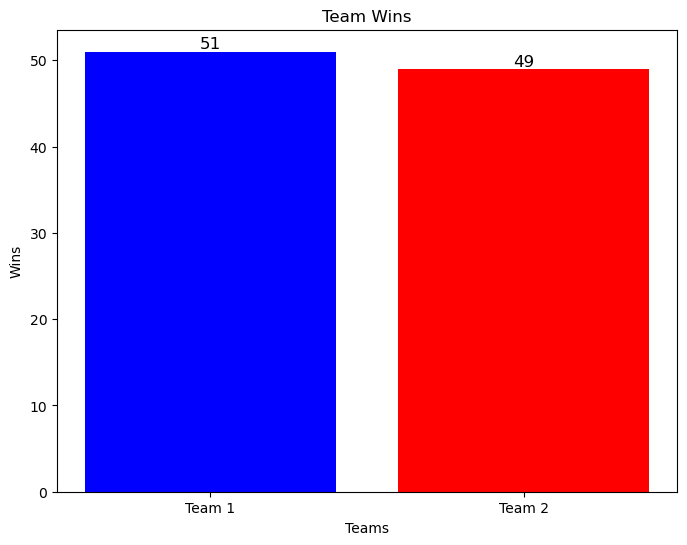

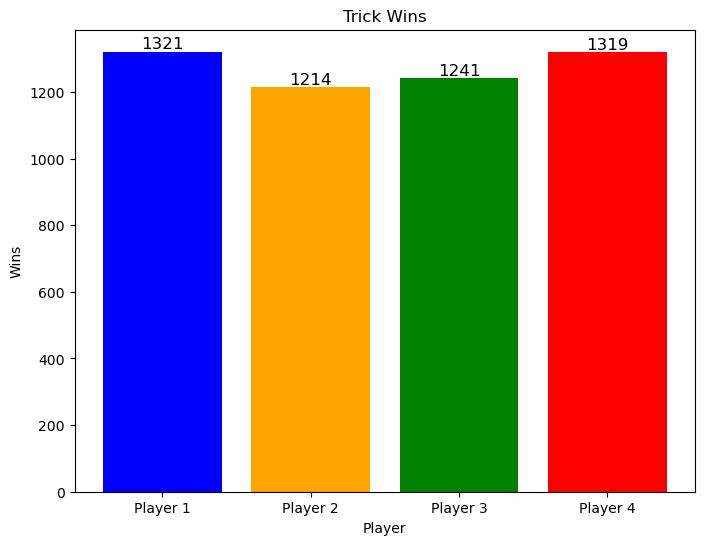

In [10]:
# plot_results(results)

## Incoporate Agents to Learn

TODO

In [10]:
env_config = {
    'score_to_win': 10,
    'values': ['9','10','J','Q','K','A'],
}
euchre = Euchre(env_config)

In [11]:
# players = [
#     RandomAgent(id=id + 1, team_id=1 if id % 2 == 0 else 2, train=False, name=f'RA {id + 1}') for id in range(euchre.num_players)
# ]

dqn_config = {
        'gamma': 0.9,  # the discount factor
        'epsilon': 0.1,  # the epsilon-greedy parameter
        'alpha': 0.001,  # the learning rate
        'input_size': 81,
        'hidden_size': 128,  # the hidden layer size
        'A': np.array(list(euchre.card_num.values())).tolist() + [-1, -2, -3] + (np.array(list(euchre.suit_num.values())) - 7).tolist(),  # the action set
        'M': 100000, # set the memory size
        'B': 64,  # set the batch size
        'C': 500,  # when to update the target approximator
        'n_steps': 100,  # the number of steps to use to update
        'epsilon_burnin': 10000,
        'double_dqn': False,
        'prioritized_replay': False,
        'multi_step': False,
        'omega': 0.05,
        'beta': 0.5,
        'n_step_return': 20,
        'card_values': euchre.card_num
}
players = [
    DQNAgent(id=1, team_id=1, train=True, name='DQN 1', config=dqn_config),
    DQNAgent(id=2, team_id=2, train=True, name='DQN 2', config=dqn_config),
    DQNAgent(id=3, team_id=1, train=True, name='DQN 3', config=dqn_config),
    DQNAgent(id=4, team_id=2, train=True, name='DQN 4', config=dqn_config)
]

In [ ]:
count = 0
episodes = 10000
debug = False

# store results of training
results = {
    'team_wins': [],
    'hand_wins': [],
    'trick_wins': [],
}

for epi in tqdm.tqdm(range(episodes)):  # loop through episodes
    players = euchre.reset_game(players=players)  # reset game (will reset hand and trick)
    hands = 1  # keep track of which game we are on
    done = False  # use to show when game is done

    while not done: # continue until game is complete
        count += 1

        ################################################## phase 0: bidding ##################################################
        curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
        phase = 0
        if debug: 
            print('Bidding')
            print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')

        for x in range(euchre.num_players):
            curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
            
            s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

            # choose the action
            action = curr_p.choose_action(state={
                's_t': s_t,
                'env': euchre,
                'phase': phase,
                'suits': [euchre.suit_num[suit] for suit in euchre.suits],
                'top_card': euchre.card_num[euchre.top_card],
                'lead_suit': euchre.lead_suit,
                's_t': s_t,
                'count': count,
                'episode': epi
            })

            # store current state, action and state/action
            curr_p.data_t = {
                's_t': s_t,
                'a_t': action,
                'd_s_a': s_t + [action]
            }

            action_str = "pass" if action == -3 else "order_up"  # convert action back to string
            next_step = euchre.step(
                action=action,
                player=curr_p,
                iteration = x + 1,
                phase_str = "bidding",
                action_str = action_str,
            )  # step

            # print(next_step)

            if curr_p.train:  # train agent
                curr_p.train_update(
                    state_t_1=next_step['state'],
                    reward_t_1=next_step['reward'],
                    done=next_step['done'],
                    count=count
                )
            
            if action_str == "order_up":  # break if order up
                player_id_choose_trump = curr_p.id
                break

            curr_p_id = curr_p_id % 4 + 1  # move to next player
        
        ################################################## phase 1: remove card ##################################################
        if action_str == "order_up":
            phase = 1
            curr_p_id = euchre.dealer_id  # only the dealer can remove card
            curr_p = [p for p in players if p.id == curr_p_id][0]

            if debug: 
                print('Order Up: Dealer Removing Card')
                print(f'Dealer Id: {euchre.dealer_id}, Current Player Id: {curr_p_id}')
        
            s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player
            before_hand = curr_p.hand  # get hand before player chooses action

            # choose the action
            action = curr_p.choose_action(state={
                's_t': s_t,
                'env': euchre,
                'phase': phase,
                'suits': [euchre.suit_num[suit] for suit in euchre.suits],
                'top_card': euchre.top_card,
                'lead_suit': euchre.lead_suit,
                's_t': s_t,
                'count': count,
                'episode': epi
            })

            # store current state, action and state/action
            curr_p.data_t = {
                's_t': s_t,
                'a_t': action,
                'd_s_a': s_t + [action]
            }

            next_step = euchre.step(
                action=action,
                player=curr_p,
                before_hand=before_hand,
                phase_str="remove_card"
            )  # step

            # print(next_step)

            if curr_p.train:  # train agent
                curr_p.train_update(
                    state_t_1=next_step['state'],
                    reward_t_1=next_step['reward'],
                    done=next_step['done'],
                    count=count
                )

        ################################################## phase 2: trump selection ##################################################
        else:
            curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
            phase = 2
            if debug: 
                print('Trump Selection')
                print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')

            for x in range(euchre.num_players):
                curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
                
                s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

                # choose the action
                action = curr_p.choose_action(state={
                    's_t': s_t,
                    'env': euchre,
                    'phase': phase,
                    'suits': (np.array(list(euchre.suit_num.values())) - 7).tolist(),
                    'top_card': euchre.card_num[euchre.top_card],
                    'lead_suit': euchre.lead_suit,
                    's_t': s_t,
                    'count': count,
                    'episode': epi,
                    'dealer': False if x + 1 != 4 else True
                })

                # store current state, action and state/action
                curr_p.data_t = {
                    's_t': s_t,
                    'a_t': action,
                    'd_s_a': s_t + [action]
                }

                action_str = "pass" if action == -1 else "select_trump"  # convert action back to string
                trump_suit = -1 if action == -1 else euchre.suits[list(np.array(list(euchre.suit_num.values())) - 7).index(action)]
                next_step = euchre.step(
                    action=action,
                    player=curr_p,
                    iteration = x + 1,
                    phase_str = "trump_selection",
                    action_str = action_str,
                    trump_suit = trump_suit
                )  # step

                # print(next_step)

                if curr_p.train:  # train agent
                    curr_p.train_update(
                        state_t_1=next_step['state'],
                        reward_t_1=next_step['reward'],
                        done=next_step['done'],
                        count=count
                    )
                
                if action_str == "select_trump":  # break if player selected trump
                    player_id_choose_trump = curr_p.id
                    break

                curr_p_id = curr_p_id % 4 + 1  # move to next player

        ################################################## phase 3: tricks ##################################################
        curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
        phase = 3
        if debug: 
            print('Trick Selection')
            print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')
        
        player_choose_trump = [p for p in players if p.id == player_id_choose_trump][0]
        player_choose_trump.trick_team = 'makers'  # assign the first player as the Makers

        makers = player_choose_trump.team_id  # set makers to player team who chose trump
        for player in players:
            player.trick_team = 'makers' if player.team_id == makers else 'defenders'

        for i in range(5):  # loop through 5 tricks (each player should have 5 cards)
            euchre.lead_suit = -1  # init lead suit to empty

            actions = {}

            # if debug:
            #     for player in players: print(vars(player))

            # loop through each player for their turn
            for x in range(euchre.num_players):  # loop through each players
                curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
                
                s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

                action = curr_p.choose_action(state={
                    's_t': s_t,
                    'env': euchre,
                    'phase': phase,
                    'lead_suit': euchre.lead_suit,
                    'hand': curr_p.hand,
                    's_t': s_t,
                    'count': count,
                    'episode': epi,
                })  # choose the action

                actions[curr_p_id] = euchre.master_deck[list(euchre.card_num.values()).index(action)]
                
                # store current state, action and state/action
                curr_p.data_t = {
                    's_t': s_t,
                    'a_t': action,
                    'd_s_a': s_t + [action]
                }

                if x == 0:  # if it is the first player, determine the lead suit
                    euchre.lead_suit = re.findall(euchre.regex_suits, curr_p.current_card)[0] # use regex

                next_step = euchre.step(
                    action=euchre.master_deck[list(euchre.card_num.values()).index(action)],
                    player=curr_p,
                    iteration = x + 1,
                    phase_str = "trick",
                )  # step

                # print(next_step)

                if curr_p.train:  # train agent
                    curr_p.train_update(
                        state_t_1=next_step['state'],
                        reward_t_1=next_step['reward'],
                        done=next_step['done'],
                        count=count
                    )

                curr_p_id = curr_p_id % 4 + 1  # move to next player

            highest_player_id = euchre.score.score_trick(actions=actions, trump_suit=euchre.trump_suit, lead_suit=euchre.lead_suit)
            highest_player = [p for p in players if p.id == highest_player_id][0]  # get player who won trick
            highest_player.points += 1  # update their points by 1 for the hand
            curr_p_id = highest_player_id

            results['trick_wins'].append(highest_player_id)

            euchre.reset_trick()

            if debug:
                print("==================================================")
                print(f'Trump Suit: {euchre.trump_suit}; Lead Suit: {euchre.lead_suit}')
                for player in players: print(vars(player))
                print('Actions:\n', actions)
                print('Player Id Who Won Trick:', highest_player.id)

        done = euchre.update_team_scores(players, player_team_id_trump=player_choose_trump.team_id)

        if debug: 
            print(f'\n\nHand {hands} Recap\t\t Team 1 Score: {euchre.team_1_score}\t\tTeam 2 Score: {euchre.team_2_score}')
            for player in players: print(f'Player {player.id} Points ({player.trick_team} & {player.team_id}): {player.points}')

        hands += 1  # update hand counter
        players = euchre.reset_hand(players=players)  # reset hand

    results['team_wins'].append(1 if euchre.team_1_score >= 10 else 2)
    
    if debug: 
        print('Team 1 Wins' if euchre.team_1_score >= 10 else 'Team 2 Wins')

  1%|          | 56/10000 [00:07<23:30,  7.05it/s]


KeyboardInterrupt: 

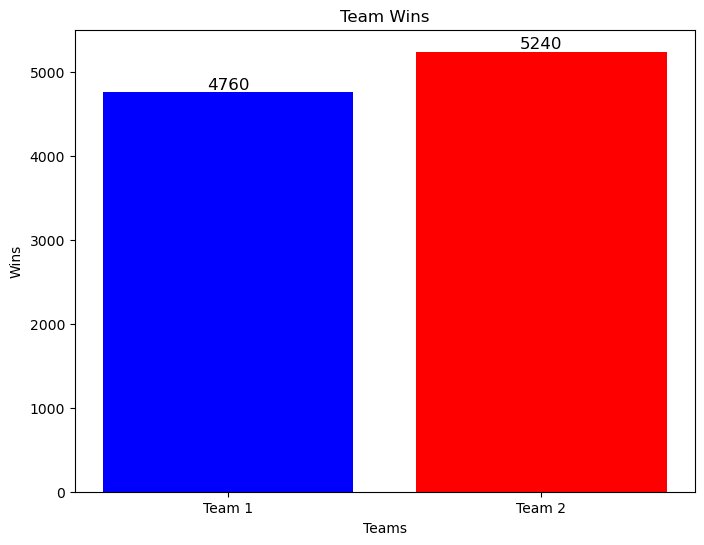

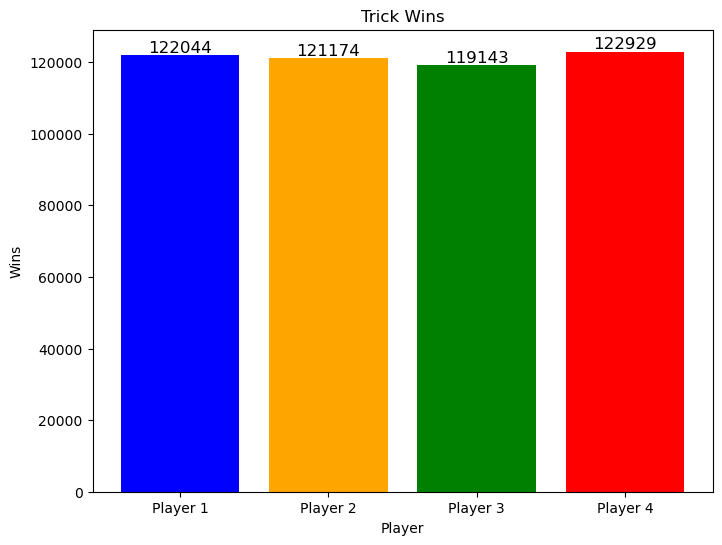

In [154]:
plot_results(results)

Save Players

In [156]:
# with open('players_new.pkl', 'wb') as f:
#     pickle.dump(players, f)

Load Players

In [ ]:
with open('players.pkl', 'rb') as f:
    players = pickle.load(f)

## Random Agents

In [37]:
env_config = {
    'score_to_win': 10,
    'values': ['9','10','J','Q','K','A'],
}
euchre = Euchre(env_config)

In [38]:
config = {
    'A': np.array(list(euchre.card_num.values())).tolist() + [-1, -2, -3] + (np.array(list(euchre.suit_num.values())) - 7).tolist(),  # the action set
    'card_values': euchre.card_num
}

players = [
    RandomAgent(id=id + 1, team_id=1 if id % 2 == 0 else 2, train=False, name=f'RA {id + 1}', config=config) for id in range(euchre.num_players)
]

In [39]:
count = 0
episodes = 1000
debug = False

# store results of training
results = {
    'team_wins': [],
    'hand_wins': [],
    'trick_wins': [],
}

for epi in tqdm.tqdm(range(episodes)):  # loop through episodes
    players = euchre.reset_game(players=players)  # reset game (will reset hand and trick)
    hands = 1  # keep track of which game we are on
    done = False  # use to show when game is done

    while not done: # continue until game is complete
        count += 1

        ################################################## phase 0: bidding ##################################################
        curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
        phase = 0
        if debug: 
            print('Bidding')
            print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')

        for x in range(euchre.num_players):
            curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
            
            s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

            # choose the action
            action = curr_p.choose_action(state={
                's_t': s_t,
                'env': euchre,
                'phase': phase,
                'suits': [euchre.suit_num[suit] for suit in euchre.suits],
                'top_card': euchre.card_num[euchre.top_card],
                'lead_suit': euchre.lead_suit,
                's_t': s_t,
                'count': count,
                'episode': epi
            })

            # store current state, action and state/action
            curr_p.data_t = {
                's_t': s_t,
                'a_t': action,
                'd_s_a': s_t + [action]
            }

            action_str = "pass" if action == -3 else "order_up"  # convert action back to string
            next_step = euchre.step(
                action=action,
                player=curr_p,
                iteration = x + 1,
                phase_str = "bidding",
                action_str = action_str,
            )  # step

            # print(next_step)

            if curr_p.train:  # train agent
                curr_p.train_update(
                    state_t_1=next_step['state'],
                    reward_t_1=next_step['reward'],
                    done=next_step['done'],
                    count=count
                )
            
            if action_str == "order_up":  # break if order up
                player_id_choose_trump = curr_p.id
                break

            curr_p_id = curr_p_id % 4 + 1  # move to next player
        
        ################################################## phase 1: remove card ##################################################
        if action_str == "order_up":
            phase = 1
            curr_p_id = euchre.dealer_id  # only the dealer can remove card
            curr_p = [p for p in players if p.id == curr_p_id][0]

            if debug: 
                print('Order Up: Dealer Removing Card')
                print(f'Dealer Id: {euchre.dealer_id}, Current Player Id: {curr_p_id}')
        
            s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player
            before_hand = curr_p.hand  # get hand before player chooses action

            # choose the action
            action = curr_p.choose_action(state={
                's_t': s_t,
                'env': euchre,
                'phase': phase,
                'suits': [euchre.suit_num[suit] for suit in euchre.suits],
                'top_card': euchre.top_card,
                'lead_suit': euchre.lead_suit,
                's_t': s_t,
                'count': count,
                'episode': epi
            })

            # store current state, action and state/action
            curr_p.data_t = {
                's_t': s_t,
                'a_t': action,
                'd_s_a': s_t + [action]
            }

            next_step = euchre.step(
                action=action,
                player=curr_p,
                before_hand=before_hand,
                phase_str="remove_card"
            )  # step

            # print(next_step)

            if curr_p.train:  # train agent
                curr_p.train_update(
                    state_t_1=next_step['state'],
                    reward_t_1=next_step['reward'],
                    done=next_step['done'],
                    count=count
                )

        ################################################## phase 2: trump selection ##################################################
        else:
            curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
            phase = 2
            if debug: 
                print('Trump Selection')
                print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')

            for x in range(euchre.num_players):
                curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
                
                s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

                # choose the action
                action = curr_p.choose_action(state={
                    's_t': s_t,
                    'env': euchre,
                    'phase': phase,
                    'suits': (np.array(list(euchre.suit_num.values())) - 7).tolist(),
                    'top_card': euchre.card_num[euchre.top_card],
                    'lead_suit': euchre.lead_suit,
                    's_t': s_t,
                    'count': count,
                    'episode': epi,
                    'dealer': False if x + 1 != 4 else True
                })

                # store current state, action and state/action
                curr_p.data_t = {
                    's_t': s_t,
                    'a_t': action,
                    'd_s_a': s_t + [action]
                }

                action_str = "pass" if action == -1 else "select_trump"  # convert action back to string
                trump_suit = -1 if action == -1 else euchre.suits[list(np.array(list(euchre.suit_num.values())) - 7).index(action)]
                next_step = euchre.step(
                    action=action,
                    player=curr_p,
                    iteration = x + 1,
                    phase_str = "trump_selection",
                    action_str = action_str,
                    trump_suit = trump_suit
                )  # step

                # print(next_step)

                if curr_p.train:  # train agent
                    curr_p.train_update(
                        state_t_1=next_step['state'],
                        reward_t_1=next_step['reward'],
                        done=next_step['done'],
                        count=count
                    )
                
                if action_str == "select_trump":  # break if player selected trump
                    player_id_choose_trump = curr_p.id
                    break

                curr_p_id = curr_p_id % 4 + 1  # move to next player

        ################################################## phase 3: tricks ##################################################
        curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
        phase = 3
        if debug: 
            print('Trick Selection')
            print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')
        
        player_choose_trump = [p for p in players if p.id == player_id_choose_trump][0]
        player_choose_trump.trick_team = 'makers'  # assign the first player as the Makers

        makers = player_choose_trump.team_id  # set makers to player team who chose trump
        for player in players:
            player.trick_team = 'makers' if player.team_id == makers else 'defenders'

        for i in range(5):  # loop through 5 tricks (each player should have 5 cards)
            euchre.lead_suit = -1  # init lead suit to empty

            actions = {}

            # if debug:
            #     for player in players: print(vars(player))

            # loop through each player for their turn
            for x in range(euchre.num_players):  # loop through each players
                curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
                
                s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

                action = curr_p.choose_action(state={
                    's_t': s_t,
                    'env': euchre,
                    'phase': phase,
                    'lead_suit': euchre.lead_suit,
                    'hand': curr_p.hand,
                    's_t': s_t,
                    'count': count,
                    'episode': epi,
                })  # choose the action

                actions[curr_p_id] = euchre.master_deck[list(euchre.card_num.values()).index(action)]
                
                # store current state, action and state/action
                curr_p.data_t = {
                    's_t': s_t,
                    'a_t': action,
                    'd_s_a': s_t + [action]
                }

                if x == 0:  # if it is the first player, determine the lead suit
                    euchre.lead_suit = re.findall(euchre.regex_suits, curr_p.current_card)[0] # use regex

                next_step = euchre.step(
                    action=euchre.master_deck[list(euchre.card_num.values()).index(action)],
                    player=curr_p,
                    iteration = x + 1,
                    phase_str = "trick",
                )  # step

                # print(next_step)

                if curr_p.train:  # train agent
                    curr_p.train_update(
                        state_t_1=next_step['state'],
                        reward_t_1=next_step['reward'],
                        done=next_step['done'],
                        count=count
                    )

                curr_p_id = curr_p_id % 4 + 1  # move to next player

            highest_player_id = euchre.score.score_trick(actions=actions, trump_suit=euchre.trump_suit, lead_suit=euchre.lead_suit)
            highest_player = [p for p in players if p.id == highest_player_id][0]  # get player who won trick
            highest_player.points += 1  # update their points by 1 for the hand
            curr_p_id = highest_player_id

            results['trick_wins'].append(highest_player_id)

            euchre.reset_trick()

            if debug:
                print("==================================================")
                print(f'Trump Suit: {euchre.trump_suit}; Lead Suit: {euchre.lead_suit}')
                for player in players: print(vars(player))
                print('Actions:\n', actions)
                print('Player Id Who Won Trick:', highest_player.id)

        done = euchre.update_team_scores(players, player_team_id_trump=player_choose_trump.team_id)

        if debug: 
            print(f'\n\nHand {hands} Recap\t\t Team 1 Score: {euchre.team_1_score}\t\tTeam 2 Score: {euchre.team_2_score}')
            for player in players: print(f'Player {player.id} Points ({player.trick_team} & {player.team_id}): {player.points}')

        hands += 1  # update hand counter
        players = euchre.reset_hand(players=players)  # reset hand

    results['team_wins'].append(1 if euchre.team_1_score >= 10 else 2)
    
    if debug: 
        print('Team 1 Wins' if euchre.team_1_score >= 10 else 'Team 2 Wins')

100%|██████████| 1000/1000 [00:09<00:00, 101.12it/s]


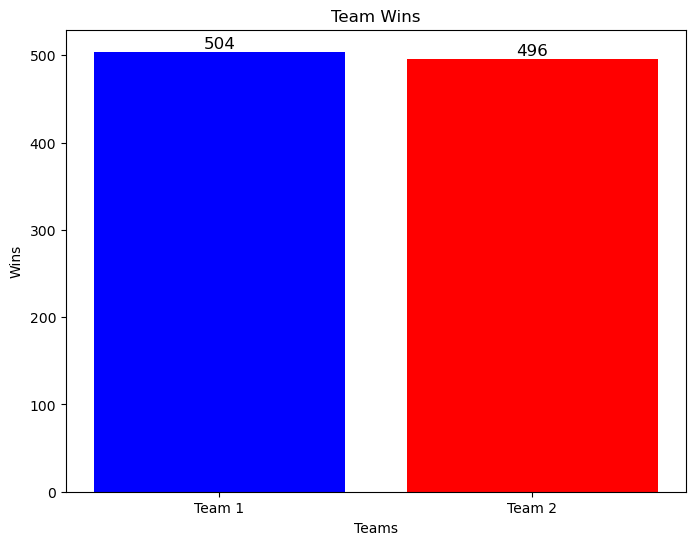

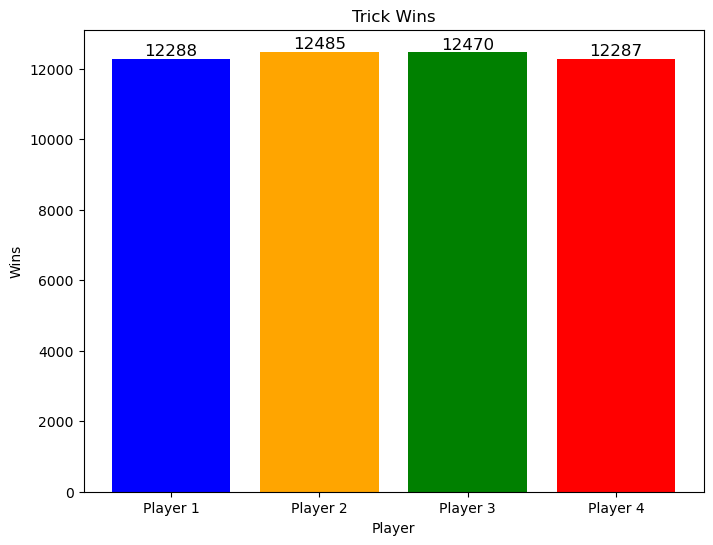

In [40]:
plot_results(results)

## Evaluate with Trained and Random Agents

In [41]:
with open('players_new.pkl', 'rb') as f:
    players = pickle.load(f)

In [42]:
player1 = players[0]
player1.train = False
player3 = players[2]
player3.train = False

In [44]:
config = {
    'A': np.array(list(euchre.card_num.values())).tolist() + [-1, -2, -3] + (np.array(list(euchre.suit_num.values())) - 7).tolist(),  # the action set
    'card_values': euchre.card_num
}

players = [
    player1,
    RandomAgent(id=2, team_id=2, train=False, name=f'RA 1', config=config),
    RandomAgent(id=3, team_id=1, train=False, name=f'RA 2', config=config),
    RandomAgent(id=4, team_id=2, train=False, name=f'RA 3', config=config)
]

In [46]:
count = 0
episodes = 1000
debug = False

# store results of training
results = {
    'team_wins': [],
    'hand_wins': [],
    'trick_wins': [],
}

for epi in tqdm.tqdm(range(episodes)):  # loop through episodes
    players = euchre.reset_game(players=players)  # reset game (will reset hand and trick)
    hands = 1  # keep track of which game we are on
    done = False  # use to show when game is done

    while not done: # continue until game is complete
        count += 1

        ################################################## phase 0: bidding ##################################################
        curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
        phase = 0
        if debug: 
            print('Bidding')
            print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')

        for x in range(euchre.num_players):
            curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
            
            s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

            # choose the action
            action = curr_p.choose_action(state={
                's_t': s_t,
                'env': euchre,
                'phase': phase,
                'suits': [euchre.suit_num[suit] for suit in euchre.suits],
                'top_card': euchre.card_num[euchre.top_card],
                'lead_suit': euchre.lead_suit,
                's_t': s_t,
                'count': count,
                'episode': epi
            })

            # store current state, action and state/action
            curr_p.data_t = {
                's_t': s_t,
                'a_t': action,
                'd_s_a': s_t + [action]
            }

            action_str = "pass" if action == -3 else "order_up"  # convert action back to string
            next_step = euchre.step(
                action=action,
                player=curr_p,
                iteration = x + 1,
                phase_str = "bidding",
                action_str = action_str,
            )  # step

            # print(next_step)

            if curr_p.train:  # train agent
                curr_p.train_update(
                    state_t_1=next_step['state'],
                    reward_t_1=next_step['reward'],
                    done=next_step['done'],
                    count=count
                )
            
            if action_str == "order_up":  # break if order up
                player_id_choose_trump = curr_p.id
                break

            curr_p_id = curr_p_id % 4 + 1  # move to next player
        
        ################################################## phase 1: remove card ##################################################
        if action_str == "order_up":
            phase = 1
            curr_p_id = euchre.dealer_id  # only the dealer can remove card
            curr_p = [p for p in players if p.id == curr_p_id][0]

            if debug: 
                print('Order Up: Dealer Removing Card')
                print(f'Dealer Id: {euchre.dealer_id}, Current Player Id: {curr_p_id}')
        
            s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player
            before_hand = curr_p.hand  # get hand before player chooses action

            # choose the action
            action = curr_p.choose_action(state={
                's_t': s_t,
                'env': euchre,
                'phase': phase,
                'suits': [euchre.suit_num[suit] for suit in euchre.suits],
                'top_card': euchre.top_card,
                'lead_suit': euchre.lead_suit,
                's_t': s_t,
                'count': count,
                'episode': epi
            })

            # store current state, action and state/action
            curr_p.data_t = {
                's_t': s_t,
                'a_t': action,
                'd_s_a': s_t + [action]
            }

            next_step = euchre.step(
                action=action,
                player=curr_p,
                before_hand=before_hand,
                phase_str="remove_card"
            )  # step

            # print(next_step)

            if curr_p.train:  # train agent
                curr_p.train_update(
                    state_t_1=next_step['state'],
                    reward_t_1=next_step['reward'],
                    done=next_step['done'],
                    count=count
                )

        ################################################## phase 2: trump selection ##################################################
        else:
            curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
            phase = 2
            if debug: 
                print('Trump Selection')
                print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')

            for x in range(euchre.num_players):
                curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
                
                s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

                # choose the action
                action = curr_p.choose_action(state={
                    's_t': s_t,
                    'env': euchre,
                    'phase': phase,
                    'suits': (np.array(list(euchre.suit_num.values())) - 7).tolist(),
                    'top_card': euchre.card_num[euchre.top_card],
                    'lead_suit': euchre.lead_suit,
                    's_t': s_t,
                    'count': count,
                    'episode': epi,
                    'dealer': False if x + 1 != 4 else True
                })

                # store current state, action and state/action
                curr_p.data_t = {
                    's_t': s_t,
                    'a_t': action,
                    'd_s_a': s_t + [action]
                }

                action_str = "pass" if action == -1 else "select_trump"  # convert action back to string
                trump_suit = -1 if action == -1 else euchre.suits[list(np.array(list(euchre.suit_num.values())) - 7).index(action)]
                next_step = euchre.step(
                    action=action,
                    player=curr_p,
                    iteration = x + 1,
                    phase_str = "trump_selection",
                    action_str = action_str,
                    trump_suit = trump_suit
                )  # step

                # print(next_step)

                if curr_p.train:  # train agent
                    curr_p.train_update(
                        state_t_1=next_step['state'],
                        reward_t_1=next_step['reward'],
                        done=next_step['done'],
                        count=count
                    )
                
                if action_str == "select_trump":  # break if player selected trump
                    player_id_choose_trump = curr_p.id
                    break

                curr_p_id = curr_p_id % 4 + 1  # move to next player

        ################################################## phase 3: tricks ##################################################
        curr_p_id = euchre.dealer_id % 4 + 1  # get current player id (left of dealer)
        phase = 3
        if debug: 
            print('Trick Selection')
            print(f'Dealer Id: {euchre.dealer_id}, First Player Id: {curr_p_id}')
        
        player_choose_trump = [p for p in players if p.id == player_id_choose_trump][0]
        player_choose_trump.trick_team = 'makers'  # assign the first player as the Makers

        makers = player_choose_trump.team_id  # set makers to player team who chose trump
        for player in players:
            player.trick_team = 'makers' if player.team_id == makers else 'defenders'

        for i in range(5):  # loop through 5 tricks (each player should have 5 cards)
            euchre.lead_suit = -1  # init lead suit to empty

            actions = {}

            # if debug:
            #     for player in players: print(vars(player))

            # loop through each player for their turn
            for x in range(euchre.num_players):  # loop through each players
                curr_p = [p for p in players if p.id == curr_p_id][0]  # get current player object
                
                s_t = euchre.get_state(curr_p, phase=phase)  # get the state based on env and current player

                action = curr_p.choose_action(state={
                    's_t': s_t,
                    'env': euchre,
                    'phase': phase,
                    'lead_suit': euchre.lead_suit,
                    'hand': curr_p.hand,
                    's_t': s_t,
                    'count': count,
                    'episode': epi,
                })  # choose the action

                actions[curr_p_id] = euchre.master_deck[list(euchre.card_num.values()).index(action)]
                
                # store current state, action and state/action
                curr_p.data_t = {
                    's_t': s_t,
                    'a_t': action,
                    'd_s_a': s_t + [action]
                }

                if x == 0:  # if it is the first player, determine the lead suit
                    euchre.lead_suit = re.findall(euchre.regex_suits, curr_p.current_card)[0] # use regex

                next_step = euchre.step(
                    action=euchre.master_deck[list(euchre.card_num.values()).index(action)],
                    player=curr_p,
                    iteration = x + 1,
                    phase_str = "trick",
                )  # step

                # print(next_step)

                if curr_p.train:  # train agent
                    curr_p.train_update(
                        state_t_1=next_step['state'],
                        reward_t_1=next_step['reward'],
                        done=next_step['done'],
                        count=count
                    )

                curr_p_id = curr_p_id % 4 + 1  # move to next player

            highest_player_id = euchre.score.score_trick(actions=actions, trump_suit=euchre.trump_suit, lead_suit=euchre.lead_suit)
            highest_player = [p for p in players if p.id == highest_player_id][0]  # get player who won trick
            highest_player.points += 1  # update their points by 1 for the hand
            curr_p_id = highest_player_id

            results['trick_wins'].append(highest_player_id)

            euchre.reset_trick()

            if debug:
                print("==================================================")
                print(f'Trump Suit: {euchre.trump_suit}; Lead Suit: {euchre.lead_suit}')
                for player in players: print(vars(player))
                print('Actions:\n', actions)
                print('Player Id Who Won Trick:', highest_player.id)

        done = euchre.update_team_scores(players, player_team_id_trump=player_choose_trump.team_id)

        if debug: 
            print(f'\n\nHand {hands} Recap\t\t Team 1 Score: {euchre.team_1_score}\t\tTeam 2 Score: {euchre.team_2_score}')
            for player in players: print(f'Player {player.id} Points ({player.trick_team} & {player.team_id}): {player.points}')

        hands += 1  # update hand counter
        players = euchre.reset_hand(players=players)  # reset hand

    results['team_wins'].append(1 if euchre.team_1_score >= 10 else 2)
    
    if debug: 
        print('Team 1 Wins' if euchre.team_1_score >= 10 else 'Team 2 Wins')

100%|██████████| 1000/1000 [00:10<00:00, 91.57it/s]


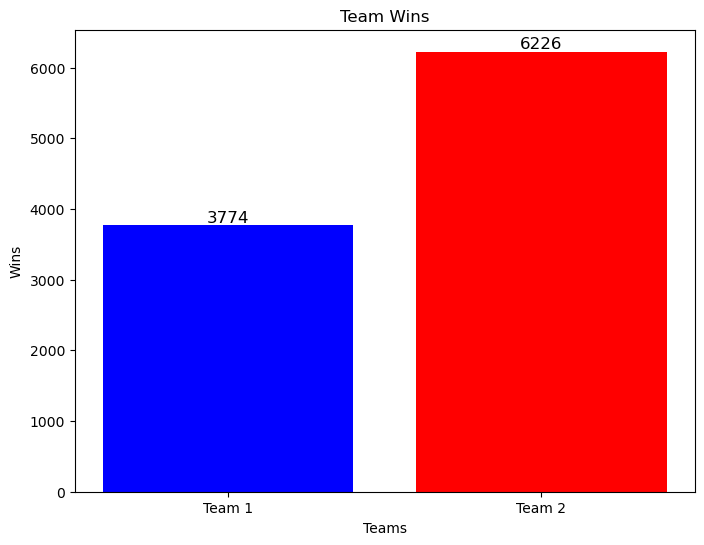

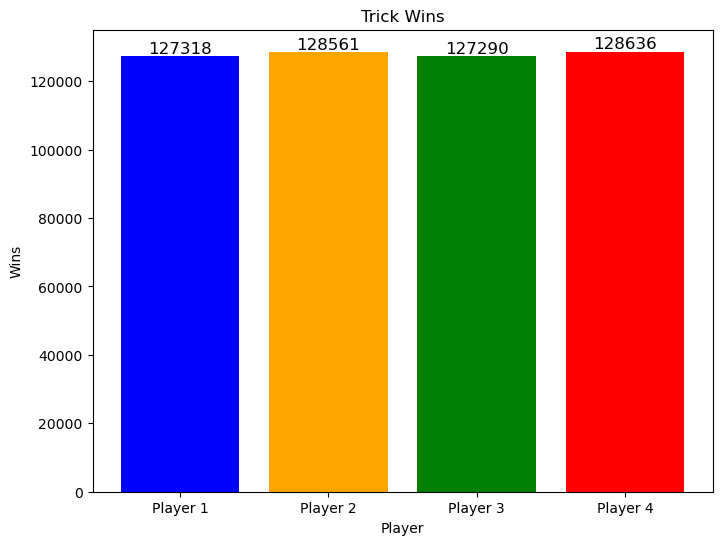

In [23]:
plot_results(results)